In [4]:
import requests
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from scipy.stats import pearsonr

BASE = "https://api.elections.kalshi.com/trade-api/v2"

In [5]:
def get_all_series():
    url = f"{BASE}/series"
    resp = requests.get(url).json()
    return pd.DataFrame(resp["series"])

def get_series(series_ticker):
    url = f"{BASE}/series/{series_ticker}"
    return requests.get(url).json()

def get_markets(series_ticker, status="open"):
    url = f"{BASE}/markets"
    params = {"series_ticker": series_ticker, "status": status}
    resp = requests.get(url, params=params).json()
    return resp

def get_market_candlesticks(series_ticker, ticker, start_ts, end_ts, period_interval=60):
    url = f"{BASE}/series/{series_ticker}/markets/{ticker}/candlesticks"
    params = {
        "start_ts": start_ts,
        "end_ts": end_ts,
        "period_interval": period_interval
    }
    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise Exception(f"Error fetching candlesticks: {resp.status_code} - {resp.text}")
    return resp.json()

In [6]:
series_df = get_all_series()
print(f"Found {len(series_df)} series")
series_df.head()

Found 7288 series


,additional_prohibitions,category,contract_terms_url,contract_url,fee_multiplier,fee_type,frequency,settlement_sources,tags,ticker,title
0,"[Current and former players, coaches, and staf...",Sports,https://kalshi-public-docs.s3.amazonaws.com/co...,https://kalshi-public-docs.s3.us-east-1.amazon...,1.0,quadratic,annual,"[{'name': 'ESPN', 'url': 'https://www.espn.com...",[Football],KXNFLWINS-BAL,Pro football wins Baltimore
1,None,Politics,https://kalshi-public-docs.s3.amazonaws.com/co...,https://kalshi-public-docs.s3.us-east-1.amazon...,1.0,quadratic,custom,[{'name': 'Office of the Mayor of New York Cit...,None,KXMAYORNYCPARTY,Mayor of NYC party winner
2,None,Politics,https://kalshi-public-docs.s3.amazonaws.com/co...,https://kalshi-public-docs.s3.us-east-1.amazon...,1.0,quadratic,custom,"[{'name': 'AP', 'url': 'https://apnews.com/'},...",[Mention],KXDJTFRENCHREP,Trump press conference WITH FRENCH REPUBLIC
3,None,Financials,https://kalshi-public-docs.s3.amazonaws.com/co...,https://kalshi-public-docs.s3.us-east-1.amazon...,1.0,quadratic,one_off,"[{'name': 'ABC', 'url': 'https://www.abc.net.a...",None,KXACQUIREMISTRAL,Will Mistral AI be acquired this year?
4,None,Entertainment,https://kalshi-public-docs.s3.amazonaws.com/co...,https://kalshi-public-docs.s3.us-east-1.amazon...,1.0,quadratic,annual,[{'name': 'Academy of Television Arts & Scienc...,"[Awards, Emmys, Television]",KXEMMYLSACTR,Emmy for Movie/Limited Supporting Actress


In [7]:
def filter_series_by_keywords(series_df, keywords):
    if series_df.empty:
        return series_df
    
    mask = series_df["title"].str.contains("|".join(keywords), case=False, na=False) | \
           series_df["ticker"].str.contains("|".join(keywords), case=False, na=False)
    
    return series_df[mask]

In [8]:
crypto_series = filter_series_by_keywords(series_df,
                                          ["BTC", "Bitcoin", "ETH", "Ethereum", "crypto"])
economics_series = filter_series_by_keywords(series_df,
                                             ["CPI", "inflation", "unemployment",
                                              "payroll", "NFP", "GDP", "jobs", "PCE"])
financials_series = filter_series_by_keywords(series_df,
                                              ["S&P", "SPX", "NASDAQ", "stock",
                                               "equity", "treasury", "yield", "bond", "VIX"])

companies_series = filter_series_by_keywords(series_df,
                                             ["AAPL", "Apple", "TSLA", "Tesla",
                                              "NVDA", "Nvidia", "AMZN", "Amazon"])

In [9]:
print("Crypto:", crypto_series["ticker"].tolist()[:10])
print("Economics:", economics_series["ticker"].tolist()[:10])
print("Financials:", financials_series["ticker"].tolist()[:10])
print("Companies:", companies_series["ticker"].tolist()[:10])

Crypto: ['KXPUBLICTRUDEAUPERRY', 'KXETH15M', 'KXETHMAXM', 'KXBTCHALF', 'KXMARRIAGESELENABENNY', 'KXSUNBELT', 'KXBETHER', 'KXARTISTCOLLABCARPENTERMINAJ', 'ETHD', 'KXHARDFORKBTC']
Economics: ['GDPUSMAX', 'LCPIMAX', 'KXPROLLS', 'U3', 'KXUSEDCAR', 'KXCPIAPPAREL', 'KXCPIEU', 'KXU3', 'U3MAX', 'GDPEU']
Financials: ['KXSTOCKXLABUBUENERGY', 'KXMUNIBONDTAX', 'KXINXU', 'INXZ', 'KXTNOTED', 'KXSTOCKXSUPREMEBOXLOGO', 'KXSTOCKX204LMUSHROOM', 'NASDAQ100M', 'KXINXI', 'KXTREASURYMAX5']
Companies: ['APPLEUS', 'KXTESLASEMI', 'KXTESLAM2', 'KXNEWPRODUCTAPPLE', 'TESLAROADSTER', 'KXRELEASEIPHONE', 'KXAPPLEAI', 'TESLAOPTIMUS', 'KXNVIDIARASGONQ', 'KXAPPLEPORT']


In [10]:
def candlesticks_to_timeseries(candlestick_data):
    if not candlestick_data or "candlesticks" not in candlestick_data:
        return None
    
    candlesticks = candlestick_data["candlesticks"]
    if not candlesticks:
        return None
    
    df = pd.DataFrame(candlesticks)
    
    time_col = None
    for col in ["start_ts", "end_period_ts", "timestamp", "time", "end_ts"]:
        if col in df.columns:
            time_col = col
            break
    
    if time_col is None:
        print("Warning: No timestamp column found in candlestick data")
        print("Available columns:", df.columns.tolist())
        return None
    
    df["time"] = pd.to_datetime(df[time_col], unit="s")
    df = df.set_index("time")
    
    if len(df) == 0:
        print("Warning: Empty candlestick data")
        return None
    
    if "yes_ask" in df.columns and len(df) > 0 and isinstance(df["yes_ask"].iloc[0], dict):
        df["price"] = df["yes_ask"].apply(lambda x: x.get("close", x.get("mean", None)) if isinstance(x, dict) else x)
        if df["price"].isna().all() and "yes_bid" in df.columns:
            df["price"] = df["yes_bid"].apply(lambda x: x.get("close", x.get("mean", None)) if isinstance(x, dict) else x)
        if df["price"].isna().any() and "yes_bid" in df.columns:
            ask_prices = df["yes_ask"].apply(lambda x: x.get("close", x.get("mean", None)) if isinstance(x, dict) else None)
            bid_prices = df["yes_bid"].apply(lambda x: x.get("close", x.get("mean", None)) if isinstance(x, dict) else None)
            df["price"] = (ask_prices + bid_prices) / 2
            df["price"] = df["price"].fillna(ask_prices).fillna(bid_prices)
    elif "price" in df.columns and len(df) > 0:
        if isinstance(df["price"].iloc[0], dict):
            df["price"] = df["price"].apply(lambda x: x.get("close", x.get("mean", None)) if isinstance(x, dict) else x)
        else:
            df["price"] = df["price"]
    elif "yes_price" in df.columns:
        df["price"] = df["yes_price"]
    else:
        print("Warning: No price column found in candlestick data")
        print("Available columns:", df.columns.tolist())
        return None
    
    df["price"] = df["price"] / 100
    df["prob"] = df["price"]
    
    if "volume" in df.columns:
        df["volume"] = df["volume"].fillna(0)
    else:
        df["volume"] = 0
    
    if "yes_ask" in df.columns and len(df) > 0 and isinstance(df["yes_ask"].iloc[0], dict):
        df["open"] = df["yes_ask"].apply(lambda x: x.get("open", None) if isinstance(x, dict) else None) / 100
        df["high"] = df["yes_ask"].apply(lambda x: x.get("high", None) if isinstance(x, dict) else None) / 100
        df["low"] = df["yes_ask"].apply(lambda x: x.get("low", None) if isinstance(x, dict) else None) / 100
        df["close"] = df["yes_ask"].apply(lambda x: x.get("close", None) if isinstance(x, dict) else None) / 100
    elif "price" in df.columns and len(df) > 0 and isinstance(df["price"].iloc[0], dict):
        price_dict = df["price"].iloc[0] if len(df) > 0 else {}
        if isinstance(price_dict, dict):
            if "open" in price_dict:
                df["open"] = df["price"].apply(lambda x: x.get("open", None) if isinstance(x, dict) else None) / 100
            if "high" in price_dict:
                df["high"] = df["price"].apply(lambda x: x.get("high", None) if isinstance(x, dict) else None) / 100
            if "low" in price_dict:
                df["low"] = df["price"].apply(lambda x: x.get("low", None) if isinstance(x, dict) else None) / 100
            if "close" in price_dict:
                df["close"] = df["price"].apply(lambda x: x.get("close", None) if isinstance(x, dict) else None) / 100
    
    df = df.sort_index()
    
    cols = ["price", "prob", "volume"]
    for ohlc_col in ["open", "high", "low", "close"]:
        if ohlc_col in df.columns:
            cols.append(ohlc_col)
    
    cols = [c for c in cols if c in df.columns]
    
    return df[cols]

def get_candlesticks_for_market(series_ticker, ticker, days_back=30, period_interval=60):
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days_back)
    
    start_ts = int(start_time.timestamp())
    end_ts = int(end_time.timestamp())
    
    try:
        data = get_market_candlesticks(series_ticker, ticker, start_ts, end_ts, period_interval)
        
        if not data or "candlesticks" not in data:
            print(f"Warning: Unexpected response structure for {ticker}")
            print(f"Response keys: {list(data.keys()) if data else 'None'}")
            if data and "candlesticks" in data and len(data["candlesticks"]) > 0:
                print(f"First candlestick keys: {list(data['candlesticks'][0].keys())}")
        
        return candlesticks_to_timeseries(data)
    except Exception as e:
        print(f"Error fetching candlesticks for {ticker}: {e}")
        import traceback
        traceback.print_exc()
        return None


def safe_read_csv(path):
    if not os.path.exists(path):
        return None
    if os.path.getsize(path) == 0:
        print(f"Empty CSV: {path}")
        return None
    try:
        df = pd.read_csv(path)
        if df.empty or (len(df.columns) == 0) or (df.shape[0] == 0 and df.shape[1] == 0):
            print(f"CSV file {path} contains no data (only whitespace/blank lines)")
            return None
        return df
    except pd.errors.EmptyDataError:
        print(f"Empty CSV (no data): {path}")
        return None
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None


def rank_markets_by_quality_candlesticks(folder="kalshi_data"):
    import glob
    
    candlestick_files = glob.glob(f"{folder}/*_candlesticks.csv")
    if not candlestick_files:
        return pd.DataFrame()
    
    results = []
    
    for file in candlestick_files:
        ticker = os.path.basename(file).replace("_candlesticks.csv", "")
        try:
            df = pd.read_csv(file, index_col=0, parse_dates=True)
            if df.empty:
                continue
            
            total_volume = df["volume"].sum() if "volume" in df.columns else 0
            volatility = df["price"].std() if "price" in df.columns and len(df) > 1 else 0
            
            results.append({
                "ticker": ticker,
                "total_volume": total_volume,
                "volatility": volatility,
                "data_points": len(df)
            })
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    if not results:
        return pd.DataFrame()
    
    df_results = pd.DataFrame(results)
    return df_results.sort_values(["total_volume", "data_points"], ascending=False)

In [11]:
test_series_list = []
if not crypto_series.empty:
    test_series_list.extend(crypto_series["ticker"].head(3).tolist())
if not economics_series.empty:
    test_series_list.extend(economics_series["ticker"].head(2).tolist())
if not financials_series.empty:
    test_series_list.extend(financials_series["ticker"].head(2).tolist())
if not companies_series.empty:
    test_series_list.extend(companies_series["ticker"].head(2).tolist())

found_market = False
for test_series in test_series_list[:10]:
    print(f"\nTesting with series: {test_series}")
    try:
        markets = get_markets(test_series)
        if "markets" in markets and len(markets["markets"]) > 0:
            print(f"Found {len(markets['markets'])} markets")
            test_market = markets["markets"][0]
            print(f"Testing market: {test_market.get('ticker', 'N/A')}")
            print(f"Market title: {test_market.get('title', 'N/A')[:60]}")
            
            end_time = datetime.now()
            start_time = end_time - timedelta(days=7)
            start_ts = int(start_time.timestamp())
            end_ts = int(end_time.timestamp())
            
            print(f"Fetching candlesticks (last 7 days)...")
            candlestick_data = get_market_candlesticks(
                test_series, 
                test_market["ticker"], 
                start_ts, 
                end_ts, 
                period_interval=60
            )
            print(f"Candlestick response keys: {list(candlestick_data.keys())}")
            if "candlesticks" in candlestick_data:
                print(f"Number of candlesticks: {len(candlestick_data['candlesticks'])}")
                if len(candlestick_data["candlesticks"]) > 0:
                    print(f"First candlestick keys: {list(candlestick_data['candlesticks'][0].keys())}")
                    print(f"First candlestick sample: {candlestick_data['candlesticks'][0]}")
                    found_market = True
                    break
    except Exception as e:
        print(f"Error: {e}")
        continue

if not found_market:
    print("\nNo markets with candlestick data found in tested series")



Testing with series: KXPUBLICTRUDEAUPERRY

Testing with series: KXETH15M

Testing with series: KXETHMAXM
Found 7 markets
Testing market: KXETHMAXM-25DEC01-5500
Market title: Will Ethereum reach above $5500 by Dec 1, 2025 at 12:00AM ET
Fetching candlesticks (last 7 days)...
Candlestick response keys: ['candlesticks', 'ticker']
Number of candlesticks: 158
First candlestick keys: ['end_period_ts', 'open_interest', 'price', 'volume', 'yes_ask', 'yes_bid']
First candlestick sample: {'end_period_ts': 1763528400, 'open_interest': 644, 'price': {'close': None, 'close_dollars': None, 'high': None, 'high_dollars': None, 'low': None, 'low_dollars': None, 'max': None, 'max_dollars': None, 'mean': None, 'mean_dollars': None, 'min': None, 'min_dollars': None, 'open': None, 'open_dollars': None, 'previous': 4, 'previous_dollars': '0.0400'}, 'volume': 0, 'yes_ask': {'close': 2, 'close_dollars': '0.0200', 'high': 2, 'high_dollars': '0.0200', 'low': 2, 'low_dollars': '0.0200', 'open': 2, 'open_dollars'

In [12]:
def plot_price(ts, title="Price Time Series"):
    plt.figure(figsize=(10, 4))
    ts["price"].plot()
    plt.title(title)
    plt.ylabel("Price (probability)")
    plt.grid(True)
    plt.show()


def plot_volume(ts, title="Volume Time Series"):
    plt.figure(figsize=(10, 4))
    ts["volume"].plot()
    plt.title(title)
    plt.ylabel("Trade Volume")
    plt.grid(True)
    plt.show()


def plot_volatility(ts, window=20):
    plt.figure(figsize=(10, 4))
    vol = ts["price"].rolling(window).std()
    vol.plot()
    plt.title(f"Rolling Volatility (window={window})")
    plt.grid(True)
    plt.show()

In [13]:
def price_volume_correlation(ts):
    return ts["price"].corr(ts["volume"])

def correlate_markets(tickers, folder="kalshi_data"):
    series = {}
    for ticker in tickers:
        candlestick_path = f"{folder}/{ticker}_candlesticks.csv"
        if os.path.exists(candlestick_path):
            df = pd.read_csv(candlestick_path, index_col=0, parse_dates=True)
            if not df.empty and "price" in df.columns:
                series[ticker] = df["price"]

    if len(series) > 1:
        return pd.DataFrame(series).corr()
    else:
        print("Need at least 2 markets for correlation")
        return pd.DataFrame()

def correlate_with_underlying(kalshi_ts, underlying_ts):
    aligned = pd.concat([kalshi_ts["price"], underlying_ts], axis=1).dropna()
    aligned.columns = ["kalshi_price", "underlying"]
    return aligned.corr()

In [14]:
def ml_linear(ts):
    import sys
    print("Starting ml_linear...", flush=True)
    sys.stdout.flush()
    
    try:
        df = ts.copy()
        print(f"Data shape: {df.shape}", flush=True)
        
        df["lag1"] = df["price"].shift(1)
        df["vol_lag"] = df["volume"].shift(1)
        df = df.dropna()
        print(f"After dropna: {df.shape}", flush=True)

        if len(df) == 0:
            raise ValueError("No data after dropna")

        X = df[["lag1", "vol_lag"]]
        y = df["price"]
        print(f"X shape: {X.shape}, y shape: {y.shape}", flush=True)

        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        print(f"Train: {X_train.shape}, Test: {X_test.shape}", flush=True)

        print("Fitting model...", flush=True)
        model = LinearRegression()
        model.fit(X_train, y_train)
        print("Model fitted", flush=True)
        
        y_pred = model.predict(X_test)
        from sklearn.metrics import r2_score
        score = r2_score(y_test, y_pred)
        print(f"Linear Regression R^2 score: {score:.4f}", flush=True)
        
        return model, score
    except Exception as e:
        print(f"Error in ml_linear: {e}", flush=True)
        import traceback
        traceback.print_exc()
        raise

def ml_rf(ts):
    df = ts.copy()
    df["lag1"] = df["price"].shift(1)
    df["vol_lag"] = df["volume"].shift(1)
    df = df.dropna()

    X = df[["lag1", "vol_lag"]]
    y = df["price"]

    model = RandomForestRegressor(n_estimators=200)
    model.fit(X, y)
    return model

def ml_xgboost(ts):
    try:
        import xgboost as xgb
        from sklearn.metrics import r2_score
        import numpy as np
    except ImportError as e:
        print(f"XGBoost not installed. Install with: pip install xgboost. Error: {e}")
        return None, None
    
    try:
        df = ts.copy()
        df["lag1"] = df["price"].shift(1)
        df["vol_lag"] = df["volume"].shift(1)
        df = df.dropna()

        if len(df) == 0:
            print("XGBoost: No data after dropna")
            return None, None

        X = df[["lag1", "vol_lag"]].values
        y = df["price"].values

        split_idx = int(len(X) * 0.8)
        X_train = X[:split_idx]
        X_test = X[split_idx:]
        y_train = y[:split_idx]
        y_test = y[split_idx:]

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"XGBoost: Invalid split - train: {len(X_train)}, test: {len(X_test)}")
            return None, None

        model = xgb.XGBRegressor(
            n_estimators=50,
            max_depth=2,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        print(f"XGBoost R^2 score: {score:.4f}")
        
        return model, score
    except Exception as e:
        print(f"XGBoost error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def ml_simple_nn(ts):
    try:
        from sklearn.neural_network import MLPRegressor
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import r2_score
    except ImportError:
        print("MLPRegressor not available")
        return None, None
    
    df = ts.copy()
    df["lag1"] = df["price"].shift(1)
    df["vol_lag"] = df["volume"].shift(1)
    df = df.dropna()

    if len(df) == 0:
        return None, None

    X = df[["lag1", "vol_lag"]].values
    y = df["price"].values

    split_idx = int(len(X) * 0.8)
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    model = MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=42, 
                        early_stopping=True, validation_fraction=0.2, alpha=0.01, learning_rate_init=0.001)
    model.fit(X_train_scaled, y_train_scaled)
    
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    score = r2_score(y_test, y_pred)
    print(f"Neural Network R^2 score: {score:.4f}")
    
    return model, score

def ml_lstm(ts):
    print("Warning: LSTM requires TensorFlow which takes a long time to load.")
    print("Consider using ml_xgboost() or ml_simple_nn() instead.")
    
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense
    except ImportError:
        print("TensorFlow not installed. Install with: pip install tensorflow")
        return None
    
    df = ts.copy()
    df["lag1"] = df["price"].shift(1)
    df["vol_lag"] = df["volume"].shift(1)
    df = df.dropna()

    if len(df) == 0:
        return None

    X = df[["lag1", "vol_lag"]].values
    y = df["price"].values

    X = X.reshape((X.shape[0], 1, X.shape[1]))

    model = Sequential([
        LSTM(32, activation="tanh", input_shape=(1, X.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=20, batch_size=16, verbose=0)

    return model

In [15]:
def load_clean_fedwatch(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path)

    date_col = raw.columns[0]
    first_meeting_label = raw.columns[1]

    df = raw[[date_col] + [
        c for c in raw.columns[1:] 
        if "History for" not in c
    ]]

    bins = df.iloc[0, 1:].tolist()
    df = df.iloc[1:].copy()
    df.columns = ["date"] + bins

    long = df.melt(id_vars="date", var_name="target_rate", value_name="probability")

    long["date"] = pd.to_datetime(long["date"], errors="coerce")

    long = long.dropna(subset=["date", "probability"])

    long["probability"] = pd.to_numeric(long["probability"], errors="coerce").fillna(0)

    bins_with_data = (
        long.groupby("target_rate")["probability"]
            .max()
    )
    bins_with_data = bins_with_data[bins_with_data > 0].index.tolist()

    filtered = long[long["target_rate"].isin(bins_with_data)]

    if filtered.duplicated(subset=["date", "target_rate"]).any():
        filtered = filtered.groupby(["date", "target_rate"])["probability"].mean().reset_index()

    ts = filtered.pivot(index="date", columns="target_rate", values="probability")
    ts = ts.sort_index()

    return ts

def correlate_with_fed_probs(kalshi_ts, cme_ts):
    aligned = pd.concat([kalshi_ts["price"], cme_ts], axis=1).dropna()
    aligned.columns = ["kalshi_prob"] + list(cme_ts.columns)
    return aligned.corr()

In [16]:
def download_kalshi_candlesticks(series_ticker, markets_list, save_folder="kalshi_data", days_back=30, period_interval=60):
    os.makedirs(save_folder, exist_ok=True)
    
    if not markets_list:
        print("No markets to download")
        return
    
    print(f"Downloading candlestick data for {len(markets_list)} markets...\n")
    
    all_data = []
    
    for market in markets_list:
        ticker = market["ticker"]
        question = market.get("title", market.get("question", "Unknown"))
        print(f"Downloading candlesticks for: {question[:60]}...")
        
        try:
            ts = get_candlesticks_for_market(series_ticker, ticker, days_back, period_interval)
            if ts is None or ts.empty:
                print(f"  No candlestick data for {ticker}, skipping")
                continue
            
            ts.to_csv(f"{save_folder}/{ticker}_candlesticks.csv")
            all_data.append(ts)
            print(f"  Downloaded {len(ts)} candlesticks")
            
            market_info = {**market, "series_ticker": series_ticker}
            pd.DataFrame([market_info]).to_csv(
                f"{save_folder}/{ticker}_info.csv", index=False)
            
            time.sleep(0.3)
            
        except Exception as e:
            print(f"  Error downloading {ticker}: {e}")
            continue
    
    if len(all_data) > 0:
        combined = pd.concat(all_data, keys=[m["ticker"] for m in markets_list if f"{m['ticker']}_candlesticks.csv" in os.listdir(save_folder)])
        combined.to_csv(f"{save_folder}/{series_ticker}_ALL_CANDLESTICKS.csv")
        print(f"\nCombined data saved to {series_ticker}_ALL_CANDLESTICKS.csv")
    
    print(f"\nDone! All data saved in folder: {save_folder}")

In [17]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2020-01-01")
btc.to_csv("data/btc_daily.csv")

/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_20078/4290390138.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


In [18]:
chosen_series_list = []

for category_name, category_df in [("crypto", crypto_series), ("economics", economics_series), 
                                     ("financials", financials_series), ("companies", companies_series)]:
    if not category_df.empty:
        for idx in range(min(3, len(category_df))):
            series_ticker = category_df.iloc[idx]["ticker"]
            markets = get_markets(series_ticker)
            if "markets" in markets and len(markets["markets"]) > 0:
                chosen_series_list.append(series_ticker)
                print(f"Found {len(markets['markets'])} markets in {series_ticker} ({category_name})")
                if len(chosen_series_list) >= 4:
                    break
        if len(chosen_series_list) >= 4:
            break

print(f"\nSelected {len(chosen_series_list)} series to download")
print("Series:", chosen_series_list)

for series_ticker in chosen_series_list:
    print(f"\n=== Processing series: {series_ticker} ===")
    markets = get_markets(series_ticker)
    
    if "markets" in markets and len(markets["markets"]) > 0:
        markets_list = markets["markets"][:5]
        print(f"Found {len(markets['markets'])} markets, downloading top {len(markets_list)}")
        download_kalshi_candlesticks(series_ticker, markets_list, days_back=30, period_interval=60)
    else:
        print(f"No markets found for {series_ticker}")

Found 7 markets in KXETHMAXM (crypto)
Found 8 markets in KXSTOCKXLABUBUENERGY (financials)
Found 1 markets in KXMUNIBONDTAX (financials)
Found 60 markets in KXINXU (financials)

Selected 4 series to download
Series: ['KXETHMAXM', 'KXSTOCKXLABUBUENERGY', 'KXMUNIBONDTAX', 'KXINXU']

=== Processing series: KXETHMAXM ===
Found 7 markets, downloading top 5

  Downloaded 628 candlesticks
  Downloaded 640 candlesticks
  Downloaded 650 candlesticks
  Downloaded 648 candlesticks
  Downloaded 653 candlesticks

Combined data saved to KXETHMAXM_ALL_CANDLESTICKS.csv

Done! All data saved in folder: kalshi_data

=== Processing series: KXSTOCKXLABUBUENERGY ===
Found 8 markets, downloading top 5

  Downloaded 150 candlesticks
  Downloaded 156 candlesticks
  Downloaded 157 candlesticks
  Downloaded 134 candlesticks
  Downloaded 119 candlesticks

Combined data saved to KXSTOCKXLABUBUENERGY_ALL_CANDLESTICKS.csv

Done! All data saved in folder: kalshi_data

=== Processing series: KXMUNIBONDTAX ===
Found 1

In [19]:
import glob

candlestick_files = glob.glob("kalshi_data/*_candlesticks.csv")
print(f"Found {len(candlestick_files)} candlestick files")

usable_markets = []
for file in candlestick_files:
    ticker = os.path.basename(file).replace("_candlesticks.csv", "")
    df = pd.read_csv(file, index_col=0, parse_dates=True)
    if not df.empty:
        total_volume = df["volume"].sum() if "volume" in df.columns else 0
        volatility = df["price"].std() if "price" in df.columns else 0
        usable_markets.append({
            "ticker": ticker,
            "total_volume": total_volume,
            "volatility": volatility,
            "data_points": len(df)
        })

if usable_markets:
    usable_markets_df = pd.DataFrame(usable_markets)
    usable_markets_df = usable_markets_df.sort_values("total_volume", ascending=False)
    print("\n=== Markets with Candlestick Data ===")
    print(usable_markets_df)
else:
    print("No usable markets found")
    usable_markets_df = pd.DataFrame()

Found 245 candlestick files

=== Markets with Candlestick Data ===
                             ticker  total_volume  volatility  data_points
84       KXBTCMINY-25-2-DEC31-80000       2284437    0.185961          717
224    KXBTCMAXY-25-DEC31-139999.99       1451098    0.087891          718
115           KXBTCRESERVE-26-JAN01        834868    0.046119          712
61       KXBTCMINY-25-2-DEC31-70000        832499    0.057087          713
145            KXINXY-25DEC31-B7100        581938    0.056723          679
..                              ...           ...         ...          ...
124        KXETH-25NOV2617-T3609.99             0    0.000000            6
123          KXTNOTEW-25NOV28-B4.26             0    0.167407           16
168            KXPCECORE-26NOV-T0.1             0    0.090431            9
119                 KXACPI-2025-4.8             0    0.000000          592
70   KXINXU-25NOV26H1600-T7424.9999             0    0.685894            2

[245 rows x 4 columns]


In [20]:
if not usable_markets_df.empty:
    top_market = usable_markets_df.iloc[0]
    top_ticker = top_market["ticker"]
    print(f"Selected top market: {top_ticker}")
    print(f"Total Volume: {top_market['total_volume']:.2f}")
    print(f"Volatility: {top_market['volatility']:.4f}")
    print(f"Data Points: {top_market['data_points']}")
else:
    print("No usable markets found. Please run the download step first.")
    top_ticker = None

Selected top market: KXBTCMINY-25-2-DEC31-80000
Total Volume: 2284437.00
Volatility: 0.1860
Data Points: 717


In [21]:
if top_ticker is None:
    print("Error: No market available. Please ensure data has been downloaded.")
    ts = None
else:
    candlestick_path = f"kalshi_data/{top_ticker}_candlesticks.csv"
    if os.path.exists(candlestick_path):
        ts = pd.read_csv(candlestick_path, index_col=0, parse_dates=True)
        print(f"Loaded {len(ts)} candlesticks")
        print(f"Date range: {ts.index.min()} to {ts.index.max()}")
    else:
        print(f"Candlestick file not found: {candlestick_path}")
        ts = None

Loaded 717 candlesticks
Date range: 2025-10-27 02:00:00 to 2025-11-26 02:00:00


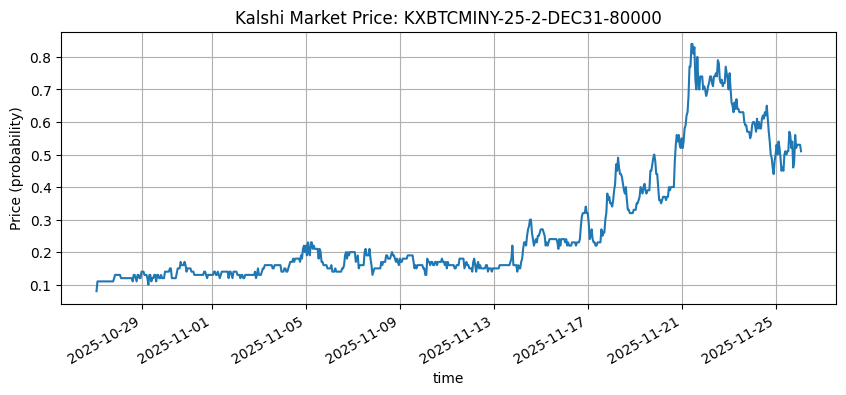

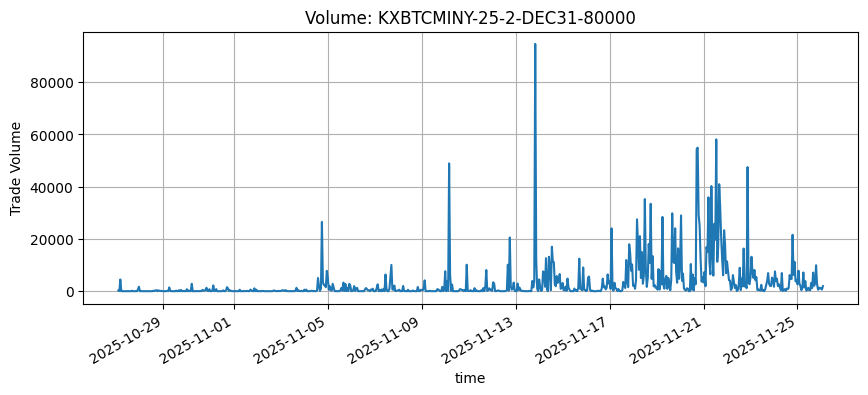

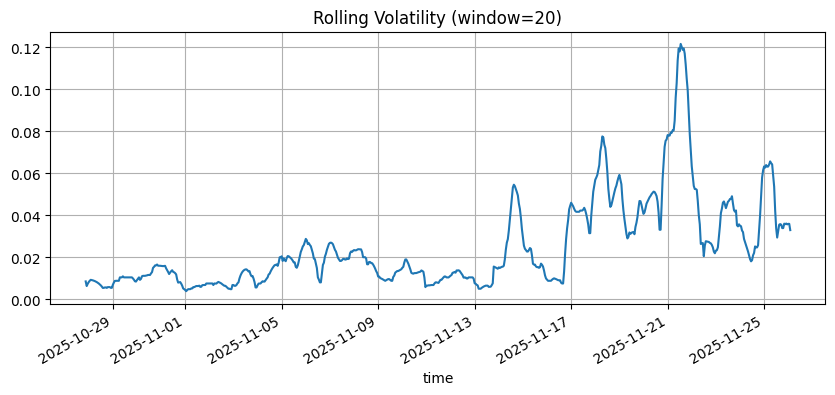

In [22]:
if ts is not None:
    plot_price(ts, title=f"Kalshi Market Price: {top_ticker}")
    plot_volume(ts, title=f"Volume: {top_ticker}")
    plot_volatility(ts)
else:
    print("Cannot plot: time series data not available")

In [23]:
if ts is not None:
    corr = price_volume_correlation(ts)
    print(f"Price-Volume Correlation: {corr:.4f}")
else:
    print("Cannot calculate correlation: time series data not available")

Price-Volume Correlation: 0.3961


In [24]:
print(f"ts variable exists: {'ts' in locals() or 'ts' in globals()}")
if "ts" in locals() or "ts" in globals():
    print(f"ts is None: {ts is None}")
    if ts is not None:
        print(f"ts type: {type(ts)}")
        print(f"ts shape: {ts.shape if hasattr(ts, 'shape') else 'N/A'}")
        print("=" * 50)
        print("Training Linear Regression model...")
        print("=" * 50)
        try:
            print("Calling ml_linear function...")
            model_lr, score_lr = ml_linear(ts)
            print("Function returned successfully!")
        except Exception as e:
            print(f"Error in ml_linear: {e}")
            import traceback
            traceback.print_exc()
            model_lr, score_lr = None, None

        if model_lr is not None:
            print("=" * 50)
            print("Training Random Forest model...")
            print("=" * 50)
            try:
                rf = ml_rf(ts)
                print("Random Forest model trained\n")
            except Exception as e:
                print(f"Error in ml_rf: {e}")
                rf = None

            print("=" * 50)
            print("Training XGBoost model (gradient boosting)...")
            print("=" * 50)
            try:
                model_xgb, score_xgb = ml_xgboost(ts)
                if model_xgb is not None:
                    print("XGBoost model trained\n")
                else:
                    print("XGBoost not available\n")
                    score_xgb = None
            except Exception as e:
                print(f"Error in XGBoost: {e}\n")
                model_xgb, score_xgb = None, None
            
            print("=" * 50)
            print("Training Neural Network model (deep learning)...")
            print("=" * 50)
            try:
                model_nn, score_nn = ml_simple_nn(ts)
                if model_nn is not None:
                    print("Neural Network model trained\n")
                else:
                    print("Neural Network not available\n")
                    score_nn = None
            except Exception as e:
                print(f"Error in Neural Network: {e}\n")
                model_nn, score_nn = None, None
            
            print("=" * 50)
            print("MODEL TRAINING COMPLETE")
            print("=" * 50)
    else:
        print("Cannot train models: ts is None")
else:
    print("Cannot train models: ts variable not defined")

ts variable exists: True
ts is None: False
ts type: <class 'pandas.core.frame.DataFrame'>
ts shape: (717, 7)
Training Linear Regression model...
Calling ml_linear function...
Starting ml_linear...
Data shape: (717, 7)
After dropna: (716, 9)
X shape: (716, 2), y shape: (716,)
Train: (572, 2), Test: (144, 2)
Fitting model...
Model fitted
Linear Regression R^2 score: 0.9299
Function returned successfully!
Training Random Forest model...
Random Forest model trained

Training XGBoost model (gradient boosting)...
XGBoost R^2 score: -1.2063
XGBoost model trained

Training Neural Network model (deep learning)...
Neural Network R^2 score: 0.8030
Neural Network model trained

MODEL TRAINING COMPLETE


In [25]:
btc_df = pd.read_csv("data/btc_daily.csv", skiprows=3)
btc_df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
btc_df["Date"] = pd.to_datetime(btc_df["Date"])
btc_df = btc_df.set_index("Date")

if ts is not None:
    correlation = correlate_with_underlying(ts, btc_df["Close"])
    print("Correlation with BTC price:")
    print(correlation)
else:
    print("Cannot correlate: time series data not available")

Correlation with BTC price:
              kalshi_price  underlying
kalshi_price      1.000000   -0.853343
underlying       -0.853343    1.000000


In [26]:
if os.path.exists("data/fedwatch.csv"):
    try:
        cme = load_clean_fedwatch("data/fedwatch.csv")
        if ts is not None:
            fed_corr = correlate_with_fed_probs(ts, cme)
            print("Correlation with FedWatch probabilities:")
            print(fed_corr)
        else:
            print("Cannot correlate: time series data not available")
    except Exception as e:
        print(f"Error loading FedWatch data: {e}")
        import traceback
        traceback.print_exc()
else:
    print("fedwatch.csv not found in data/ directory")

Correlation with FedWatch probabilities:
             kalshi_prob  (125-150)  (150-175)  (175-200)  (200-225)  \
kalshi_prob     1.000000        NaN   0.834499   0.819029   0.796604   
(125-150)            NaN        NaN        NaN        NaN        NaN   
(150-175)       0.834499        NaN   1.000000   0.997046   0.982271   
(175-200)       0.819029        NaN   0.997046   1.000000   0.993518   
(200-225)       0.796604        NaN   0.982271   0.993518   1.000000   
(225-250)       0.758136        NaN   0.949693   0.970222   0.991383   
(250-275)       0.673607        NaN   0.835098   0.869520   0.917573   
(275-300)       0.505333        NaN   0.645242   0.693013   0.765772   
(300-325)       0.027352        NaN   0.079402   0.138165   0.238456   
(325-350)      -0.580174        NaN  -0.676170  -0.644597  -0.578666   
(350-375)      -0.277279        NaN  -0.403750  -0.420871  -0.447665   
(375-400)      -0.011286        NaN  -0.009617  -0.052619  -0.126570   
(400-425)      -0.15545

Time-Series Decomposition Analysis


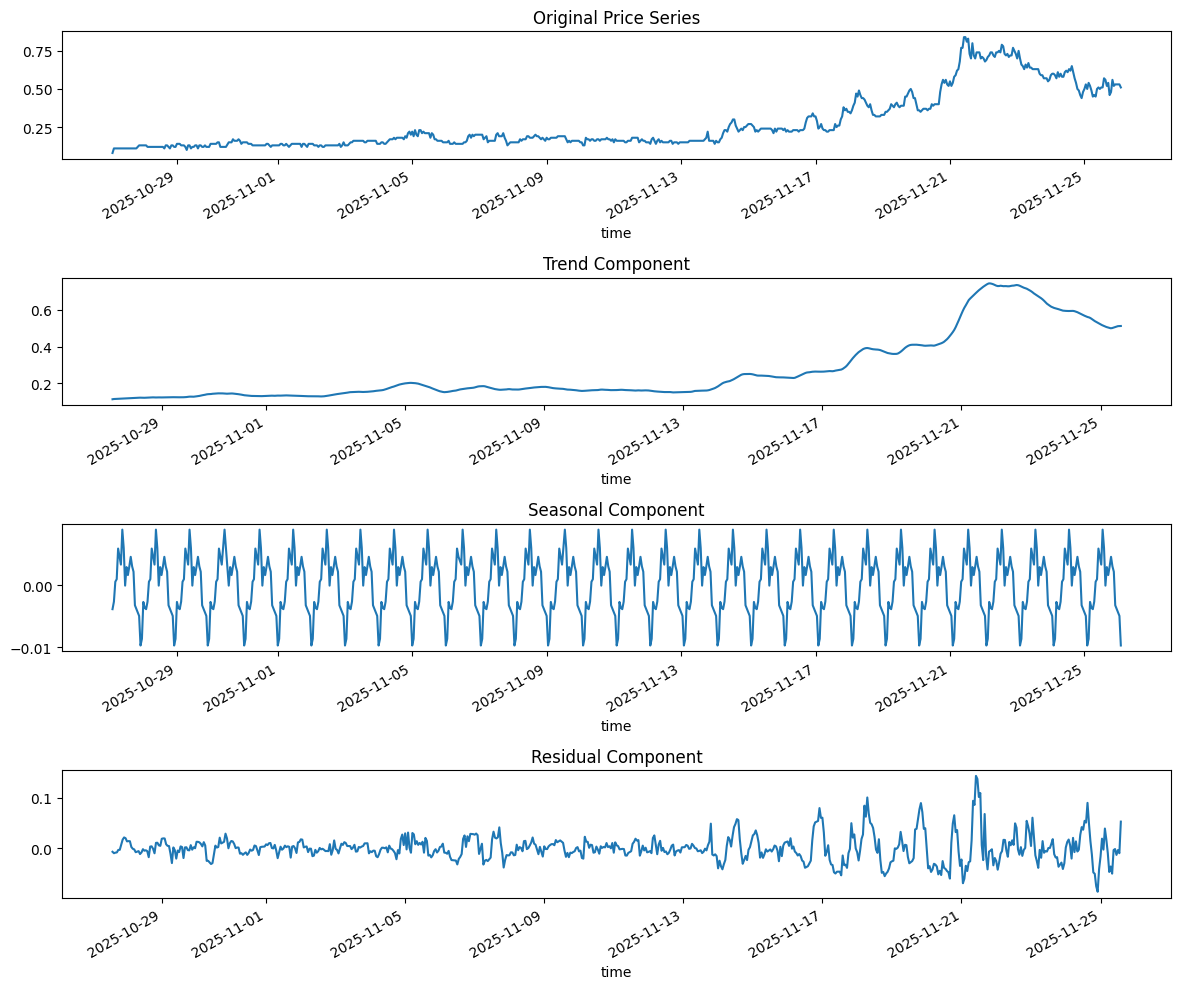


Decomposition Statistics:
Trend range: 0.1144 to 0.7425
Seasonal amplitude: 0.0186
Residual std: 0.0258


In [27]:
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
except ImportError:
    print("statsmodels not installed. Install with: pip install statsmodels")
    seasonal_decompose = None

if ts is not None and seasonal_decompose is not None:
    print("=" * 50)
    print("Time-Series Decomposition Analysis")
    print("=" * 50)
    
    price_series = ts["price"].dropna()
    if len(price_series) > 24:
        try:
            decomposition = seasonal_decompose(price_series, model='additive', period=min(24, len(price_series)//2))
            
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            decomposition.observed.plot(ax=axes[0], title='Original Price Series')
            decomposition.trend.plot(ax=axes[1], title='Trend Component')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
            decomposition.resid.plot(ax=axes[3], title='Residual Component')
            plt.tight_layout()
            plt.show()
            
            print("\nDecomposition Statistics:")
            print(f"Trend range: {decomposition.trend.min():.4f} to {decomposition.trend.max():.4f}")
            print(f"Seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.4f}")
            print(f"Residual std: {decomposition.resid.std():.4f}")
            
        except Exception as e:
            print(f"Error in decomposition: {e}")
            print("Trying with multiplicative model...")
            try:
                decomposition = seasonal_decompose(price_series, model='multiplicative', period=min(24, len(price_series)//2))
                fig, axes = plt.subplots(4, 1, figsize=(12, 10))
                decomposition.observed.plot(ax=axes[0], title='Original Price Series')
                decomposition.trend.plot(ax=axes[1], title='Trend Component')
                decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
                decomposition.resid.plot(ax=axes[3], title='Residual Component')
                plt.tight_layout()
                plt.show()
            except Exception as e2:
                print(f"Multiplicative model also failed: {e2}")
    else:
        print("Not enough data points for decomposition (need at least 24)")
else:
    print("Cannot perform decomposition: time series data not available")


Lead-Lag Analysis: Kalshi Market vs BTC Price


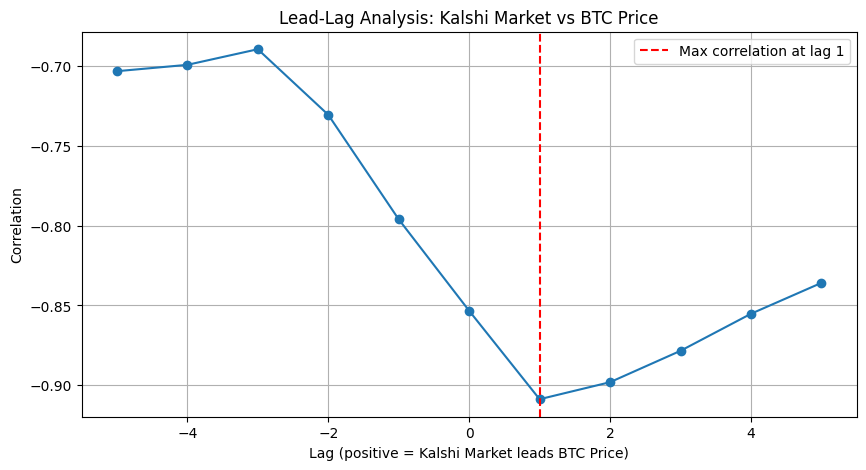


Lead-Lag Analysis Results:
Maximum correlation: -0.9088 at lag 1
Interpretation: Kalshi Market leads BTC Price by 1 periods


In [28]:
def lead_lag_analysis(ts1, ts2, max_lag=10, name1="Series 1", name2="Series 2"):
    aligned = pd.concat([ts1, ts2], axis=1).dropna()
    if len(aligned) < max_lag * 2:
        print(f"Not enough data for lead-lag analysis (need at least {max_lag*2} points)")
        return None
    
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag == 0:
            corr, _ = pearsonr(aligned.iloc[:, 0], aligned.iloc[:, 1])
        elif lag > 0:
            ts1_shifted = aligned.iloc[lag:, 0]
            ts2_shifted = aligned.iloc[:-lag, 1]
            if len(ts1_shifted) == len(ts2_shifted):
                corr, _ = pearsonr(ts1_shifted, ts2_shifted)
            else:
                corr = np.nan
        else:
            ts1_shifted = aligned.iloc[:lag, 0]
            ts2_shifted = aligned.iloc[-lag:, 1]
            if len(ts1_shifted) == len(ts2_shifted):
                corr, _ = pearsonr(ts1_shifted, ts2_shifted)
            else:
                corr = np.nan
        correlations.append(corr)
    
    correlations = np.array(correlations)
    max_corr_idx = np.nanargmax(np.abs(correlations))
    max_lag_val = lags[max_corr_idx]
    max_corr = correlations[max_corr_idx]
    
    plt.figure(figsize=(10, 5))
    plt.plot(lags, correlations, marker='o')
    plt.axvline(x=max_lag_val, color='r', linestyle='--', label=f'Max correlation at lag {max_lag_val}')
    plt.xlabel('Lag (positive = ' + name1 + ' leads ' + name2 + ')')
    plt.ylabel('Correlation')
    plt.title(f'Lead-Lag Analysis: {name1} vs {name2}')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"\nLead-Lag Analysis Results:")
    print(f"Maximum correlation: {max_corr:.4f} at lag {max_lag_val}")
    if max_lag_val > 0:
        print(f"Interpretation: {name1} leads {name2} by {max_lag_val} periods")
    elif max_lag_val < 0:
        print(f"Interpretation: {name2} leads {name1} by {abs(max_lag_val)} periods")
    else:
        print(f"Interpretation: No significant lead-lag relationship (contemporaneous)")
    
    return max_lag_val, max_corr

if ts is not None and 'btc_df' in locals():
    print("=" * 50)
    print("Lead-Lag Analysis: Kalshi Market vs BTC Price")
    print("=" * 50)
    
    kalshi_price = ts["price"]
    btc_price = btc_df["Close"]
    
    lead_lag_analysis(kalshi_price, btc_price, max_lag=5, 
                     name1="Kalshi Market", name2="BTC Price")
else:
    print("Cannot perform lead-lag analysis: time series data not available")


In [29]:
def generate_html_report(
    ts, top_ticker=None, output_file="prediction_markets_report.html"
):
    import base64
    from io import BytesIO

    html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Kalshi Prediction Markets Analysis Report</title>
<style>
body {{
  font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif;
  background: linear-gradient(180deg, #e6ebf2, #f5f7fa);
  color: #222;
  line-height: 1.6;
  margin: 0;
}}
header {{
  background: linear-gradient(135deg, #002a4e, #00558d);
  color: #fff;
  text-align: center;
  padding: 50px 20px;
  box-shadow: 0 3px 10px rgba(0,0,0,0.2);
}}
header h1 {{
  font-size: 2.2rem;
  margin: 0;
}}
header p {{
  margin-top: 10px;
  opacity: 0.9;
}}
main {{
  max-width: 1100px;
  margin: 40px auto;
  padding: 0 25px 40px 25px;
}}
.card {{
  background: linear-gradient(180deg, #ffffff, #f9fbff);
  border-radius: 14px;
  padding: 28px 35px;
  margin-bottom: 35px;
  box-shadow: 0 2px 10px rgba(0,0,0,0.08);
  transition: transform 0.2s, box-shadow 0.2s;
}}
.card:hover {{
  transform: translateY(-3px);
  box-shadow: 0 5px 14px rgba(0,0,0,0.12);
}}
.card h2 {{
  color: #003366;
  margin-top: 0;
}}
img {{
  display: block;
  margin: 20px auto;
  max-width: 65%;
  border-radius: 8px;
  box-shadow: 0 0 10px rgba(0,0,0,0.15);
}}
.table-wrapper {{
  overflow-x: auto;
  width: 100%;
  text-align: center;
}}
.styled-table {{
  border-collapse: collapse;
  width: 90%;
  margin: 20px auto;
  font-size: 0.9em;
  min-width: 400px;
}}
.wide-table {{
  width: 85%;
  font-size: 0.82em;
}}
.styled-table thead tr {{
  background-color: #004c7a;
  color: #fff;
}}
.styled-table th, .styled-table td {{
  border: 1px solid #ddd;
  padding: 6px 8px;
  text-align: center;
}}
.styled-table tbody tr:nth-child(even) {{
  background-color: #f2f6fb;
}}
.metric-box {{
  background: #e8f4f8;
  border-left: 4px solid #00558d;
  padding: 15px;
  margin: 10px 0;
  border-radius: 4px;
}}
footer {{
  text-align: center;
  color: #777;
  font-size: 0.9em;
  padding: 25px;
  background: linear-gradient(135deg, #004c7a, #003366);
  color: white;
}}
</style>
</head>
<body>
<header>
  <h1>Kalshi Prediction Markets Analysis Report</h1>
</header>
<main>
"""

    if ts is None:
        html_content += """
    <div class="card">
      <h2>Error</h2>
      <p>No time series data available. Please run the data collection cells first.</p>
    </div>
"""
    else:
        market_name = top_ticker if top_ticker else "Selected Market"

        html_content += f"""
    <div class="card">
      <h2>Market Overview</h2>
      <div class="metric-box">
        <strong>Market Ticker:</strong> {market_name}<br>
        <strong>Data Points:</strong> {len(ts)}<br>
        <strong>Date Range:</strong> {ts.index.min().strftime("%Y-%m-%d")} to {ts.index.max().strftime("%Y-%m-%d")}<br>
        <strong>Price Range:</strong> {ts["price"].min():.4f} to {ts["price"].max():.4f}<br>
        <strong>Average Volume:</strong> {ts["volume"].mean():.2f}
      </div>
    </div>
"""

        def fig_to_base64(fig):
            buf = BytesIO()
            fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
            buf.seek(0)
            img_str = base64.b64encode(buf.read()).decode("utf-8")
            plt.close(fig)
            return img_str

        fig = plt.figure(figsize=(10, 4))
        ts["price"].plot()
        plt.title("Price Time Series")
        plt.ylabel("Price (probability)")
        plt.grid(True)
        img_str = fig_to_base64(fig)
        html_content += f"""
    <div class="card">
      <h2>Price Time Series</h2>
      <img src="data:image/png;base64,{img_str}" alt="Price Time Series">
    </div>
"""

        fig = plt.figure(figsize=(10, 4))
        ts["volume"].plot()
        plt.title("Volume Time Series")
        plt.ylabel("Trade Volume")
        plt.grid(True)
        img_str = fig_to_base64(fig)
        html_content += f"""
    <div class="card">
      <h2>Volume Time Series</h2>
      <img src="data:image/png;base64,{img_str}" alt="Volume Time Series">
    </div>
"""

        fig = plt.figure(figsize=(10, 4))
        vol = ts["price"].rolling(20).std()
        vol.plot()
        plt.title("Rolling Volatility (window=20)")
        plt.grid(True)
        img_str = fig_to_base64(fig)
        html_content += f"""
    <div class="card">
      <h2>Rolling Volatility</h2>
      <img src="data:image/png;base64,{img_str}" alt="Rolling Volatility">
    </div>
"""

        price_vol_corr = price_volume_correlation(ts)
        html_content += f"""
    <div class="card">
      <h2>Price-Volume Correlation</h2>
      <div class="metric-box">
        <strong>Correlation Coefficient:</strong> {price_vol_corr:.4f}
      </div>
    </div>
"""

        if "btc_df" in locals():
            btc_corr = correlate_with_underlying(ts, btc_df["Close"])
            btc_corr_val = btc_corr.iloc[0, 1]
            html_content += f"""
    <div class="card">
      <h2>Correlation with BTC Price</h2>
      <div class="metric-box">
        <strong>Correlation Coefficient:</strong> {btc_corr_val:.4f}
      </div>
      <div class="table-wrapper">
        <table class="styled-table">
          <thead>
            <tr>
              <th>Kalshi Price</th>
              <th>BTC Price</th>
            </tr>
          </thead>
          <tbody>
            <tr>
              <td>{btc_corr.iloc[0, 0]:.4f}</td>
              <td>{btc_corr.iloc[1, 1]:.4f}</td>
            </tr>
          </tbody>
        </table>
      </div>
    </div>
"""

        if os.path.exists("data/fedwatch.csv"):
            try:
                cme = load_clean_fedwatch("data/fedwatch.csv")
                fed_corr = correlate_with_fed_probs(ts, cme)
                fed_corr_clean = fed_corr.iloc[0, 1:].dropna()
                if len(fed_corr_clean) > 0:
                    html_content += """
    <div class="card">
      <h2>Correlation with FedWatch Probabilities</h2>
      <div class="table-wrapper">
        <table class="styled-table wide-table">
          <thead>
            <tr>
              <th>Rate Bin</th>
              <th>Correlation</th>
            </tr>
          </thead>
          <tbody>
"""
                    for rate_bin, corr_val in fed_corr_clean.items():
                        html_content += f"""
            <tr>
              <td>{rate_bin}</td>
              <td>{corr_val:.4f}</td>
            </tr>
"""
                    html_content += """
          </tbody>
        </table>
      </div>
    </div>
"""
            except Exception as e:
                html_content += f"""
    <div class="card">
      <h2>FedWatch Correlation</h2>
      <p>Error loading FedWatch data: {e}</p>
    </div>
"""

        try:
            from statsmodels.tsa.seasonal import seasonal_decompose

            price_series = ts["price"].dropna()
            if len(price_series) > 24:
                decomposition = seasonal_decompose(
                    price_series,
                    model="additive",
                    period=min(24, len(price_series) // 2),
                )

                fig, axes = plt.subplots(4, 1, figsize=(12, 10))
                decomposition.observed.plot(ax=axes[0], title="Original Price Series")
                decomposition.trend.plot(ax=axes[1], title="Trend Component")
                decomposition.seasonal.plot(ax=axes[2], title="Seasonal Component")
                decomposition.resid.plot(ax=axes[3], title="Residual Component")
                plt.tight_layout()
                img_str = fig_to_base64(fig)

                html_content += f"""
    <div class="card">
      <h2>Time-Series Decomposition</h2>
      <img src="data:image/png;base64,{img_str}" alt="Time-Series Decomposition">
      <div class="metric-box">
        <strong>Trend Range:</strong> {decomposition.trend.min():.4f} to {decomposition.trend.max():.4f}<br>
        <strong>Seasonal Amplitude:</strong> {decomposition.seasonal.max() - decomposition.seasonal.min():.4f}<br>
        <strong>Residual Std:</strong> {decomposition.resid.std():.4f}
      </div>
    </div>
"""
        except Exception as e:
            pass

        if "btc_df" in locals():
            try:
                kalshi_price = ts["price"]
                btc_price = btc_df["Close"]
                aligned = pd.concat([kalshi_price, btc_price], axis=1).dropna()

                if len(aligned) >= 10:
                    max_lag = 5
                    correlations = []
                    lags = range(-max_lag, max_lag + 1)

                    for lag in lags:
                        if lag == 0:
                            corr, _ = pearsonr(aligned.iloc[:, 0], aligned.iloc[:, 1])
                        elif lag > 0:
                            ts1_shifted = aligned.iloc[lag:, 0]
                            ts2_shifted = aligned.iloc[:-lag, 1]
                            if len(ts1_shifted) == len(ts2_shifted):
                                corr, _ = pearsonr(ts1_shifted, ts2_shifted)
                            else:
                                corr = np.nan
                        else:
                            ts1_shifted = aligned.iloc[:lag, 0]
                            ts2_shifted = aligned.iloc[-lag:, 1]
                            if len(ts1_shifted) == len(ts2_shifted):
                                corr, _ = pearsonr(ts1_shifted, ts2_shifted)
                            else:
                                corr = np.nan
                        correlations.append(corr)

                    correlations = np.array(correlations)
                    max_corr_idx = np.nanargmax(np.abs(correlations))
                    max_lag_val = lags[max_corr_idx]
                    max_corr = correlations[max_corr_idx]

                    fig = plt.figure(figsize=(10, 5))
                    plt.plot(lags, correlations, marker="o")
                    plt.axvline(
                        x=max_lag_val,
                        color="r",
                        linestyle="--",
                        label=f"Max correlation at lag {max_lag_val}",
                    )
                    plt.xlabel("Lag (positive = Kalshi Market leads BTC Price)")
                    plt.ylabel("Correlation")
                    plt.title("Lead-Lag Analysis: Kalshi Market vs BTC Price")
                    plt.grid(True)
                    plt.legend()
                    img_str = fig_to_base64(fig)

                    html_content += f"""
    <div class="card">
      <h2>Lead-Lag Analysis</h2>
      <img src="data:image/png;base64,{img_str}" alt="Lead-Lag Analysis">
      <div class="metric-box">
        <strong>Maximum Correlation:</strong> {max_corr:.4f} at lag {max_lag_val}<br>
        <strong>Interpretation:</strong> {"Kalshi Market leads BTC Price" if max_lag_val > 0 else "BTC Price leads Kalshi Market" if max_lag_val < 0 else "No significant lead-lag relationship"} by {abs(max_lag_val)} periods
      </div>
    </div>
"""
            except Exception as e:
                pass

        html_content += """
    <div class="card">
      <h2>Machine Learning Model Performance</h2>
"""

        try:
            model_lr, score_lr = ml_linear(ts)
            html_content += f"""
      <div class="metric-box">
        <strong>Linear Regression R² Score:</strong> {score_lr:.4f}
      </div>
"""
        except:
            html_content += """
      <div class="metric-box">
        <strong>Linear Regression:</strong> Not available
      </div>
"""

        try:
            model_xgb, score_xgb = ml_xgboost(ts)
            if model_xgb is not None and score_xgb is not None:
                html_content += f"""
      <div class="metric-box">
        <strong>XGBoost R² Score:</strong> {score_xgb:.4f}
      </div>
"""
            else:
                html_content += """
      <div class="metric-box">
        <strong>XGBoost:</strong> Not available
      </div>
"""
        except:
            html_content += """
      <div class="metric-box">
        <strong>XGBoost:</strong> Not available
      </div>
"""

        try:
            model_nn, score_nn = ml_simple_nn(ts)
            if model_nn is not None and score_nn is not None:
                html_content += f"""
      <div class="metric-box">
        <strong>Neural Network R² Score:</strong> {score_nn:.4f}
      </div>
"""
            else:
                html_content += """
      <div class="metric-box">
        <strong>Neural Network:</strong> Not available
      </div>
"""
        except:
            html_content += """
      <div class="metric-box">
        <strong>Neural Network:</strong> Not available
      </div>
"""

        html_content += """
    </div>
"""

    html_content += """
</main>
<footer>
  <p>Kalshi Prediction Markets Analysis Report | Generated using Python</p>
</footer>
</body>
</html>
"""

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html_content)

    print(f"HTML report generated: {output_file}")
    return output_file


if ts is not None:
    generate_html_report(
        ts, top_ticker=top_ticker if "top_ticker" in locals() else None
    )
else:
    print("Cannot generate report: time series data not available")


Starting ml_linear...
Data shape: (717, 7)
After dropna: (716, 9)
X shape: (716, 2), y shape: (716,)
Train: (572, 2), Test: (144, 2)
Fitting model...
Model fitted
Linear Regression R^2 score: 0.9299
XGBoost R^2 score: -1.2063
Neural Network R^2 score: 0.8030
HTML report generated: prediction_markets_report.html


### Findings

The BTC floor contract KXBTCMINY-25-2-DEC31-80000 is the standout: its Kalshi prices move inversely with spot BTC (ρ≈‑0.85) and even lead BTC by one hour (ρ≈‑0.91), so it’s the clearest contract-underlying linkage in the data. Rate markets are the runner-up, with Kalshi probability shifts tracking CME cut bins tightly (150–200 bp correlations ≈ 0.82–0.84). Beyond these, price-volume dynamics are modest (ρ≈0.40), and simple lag-based regressions already explain ~93% of the contract variance, implying most action is internal momentum rather than exogenous predictors.